In [ ]:
!git clone https://github.com/qphong/variational-bayesian-unlearning

Cloning into 'variational-bayesian-unlearning'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 0), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 37.92 KiB | 3.79 MiB/s, done.


In [ ]:
%cd variational-bayesian-unlearning/

/kaggle/working/variational-bayesian-unlearning


In [ ]:
!sed -i 's/import tensorflow as tf/import tensorflow.compat.v1 as tf\n\n# Disable TensorFlow 2.x behavior and enable TensorFlow 1.x behavior\ntf.disable_v2_behavior()/' *.py

# Theory

In [ ]:
# unlearn.py



# import tensorflow as tf
# import tensorflow_probability as tfp
# import numpy as np
# import scipy.special
# import time
# import sys

# class Unlearnizable():

#     def __init__(self, xdim, nparam,
#                 approximate_dist_class,
#                 approximate_dist_config,
#                 log_likelihood_func,
#                 log_prior_func,
#                 nsample=1000):
#         """
#         log_likelihood_func(theta, data) returns the log_likelihood
#             theta: (nsample,nparam)
#             data: (ndata,d)
#             return (nsample,)
#         log_prior_func(theta) returns the log prior probability
#             theta: (nsample, nparam)
#             return (nsample,)
#         """
#         self.nparam = nparam
#         self.xdim = xdim
#         self.log_likelihood_func = log_likelihood_func
#         self.log_prior_func = log_prior_func


#         self.posterior_dist = approximate_dist_class(self.nparam, **approximate_dist_config)

#         self.data_plc = tf.placeholder(shape=(None,self.xdim), dtype=tf.float64)

#         post_theta_samples = self.posterior_dist.sample(nsample)
#         # (nsample, nparam)


#         self.elbo = tf.reduce_mean(
#             self.log_likelihood_func(post_theta_samples, self.data_plc)
#             + self.log_prior_func(post_theta_samples)
#             - self.posterior_dist.log_prob(post_theta_samples) )

#         self.learn_op = tf.train.AdamOptimizer().minimize(-self.elbo, var_list=list(self.posterior_dist.param.values()))


#         self.full_data_posterior_dist = approximate_dist_class(self.nparam, **approximate_dist_config)

#         self.log_threshold = tf.Variable(0.1, dtype=tf.float64)

#         full_data_posterior_logprob_theta_samples = self.full_data_posterior_dist.log_prob(post_theta_samples)

#         log_likelihood = tf.where(tf.math.greater(full_data_posterior_logprob_theta_samples, self.log_threshold),
#             x = self.log_likelihood_func(post_theta_samples, self.data_plc),
#             y = tf.zeros(nsample, dtype=tf.float64))

#         self.eubo = tf.reduce_mean(
#                     log_likelihood
#                     + self.posterior_dist.log_prob(post_theta_samples)
#                     - full_data_posterior_logprob_theta_samples)
#                     # - self.full_data_posterior_dist.log_prob(post_theta_samples))
#         self.unlearn_op = tf.train.AdamOptimizer().minimize(self.eubo, var_list=list(self.posterior_dist.param.values()))


#         full_post_theta_samples = self.full_data_posterior_dist.sample(nsample)
#         # (nsample, nparam)

#         full_data_post_logprob_full_theta_samples = self.full_data_posterior_dist.log_prob(full_post_theta_samples)

#         log_likelihood_removed_data = self.log_likelihood_func(full_post_theta_samples, self.data_plc)
#         # (nsample,)
#         # log_likelihood_removed_data is also the weights

#         # compute the average of negative log likelihood of removed data
#         # where full_data_post_logprob_full_theta_samples >= log_threshold
#         log_likelihood_removed_data = tf.where(
#             tf.math.greater(full_data_post_logprob_full_theta_samples, self.log_threshold),
#             x = log_likelihood_removed_data,
#             y = tf.zeros_like(log_likelihood_removed_data, dtype=tf.float64))

#         # log( E_q(x|full) 1/likelihood_of_removed_data )
#         self.log_mean_inverse_likelihood = tf.reduce_logsumexp(
#             -log_likelihood_removed_data - tf.cast(np.log(nsample), dtype=tf.float64))

#         log_weights = -log_likelihood_removed_data - self.log_mean_inverse_likelihood

#         self.unlearn_elbo = tf.reduce_mean(
#             tf.exp(log_weights) * self.posterior_dist.log_prob(full_post_theta_samples))

#         self.unlearn_elbo_op = tf.train.AdamOptimizer().minimize(- self.unlearn_elbo,
#                     var_list=list(self.posterior_dist.param.values()))

#         self.sess = tf.Session()
#         self.sess.run(tf.global_variables_initializer())


#     def learn(self, data, init_post_param = None, ntrain=1000, batchsize=1000000):
#         """
#         data: (n,d)
#         learning by maximizing the ELBO
#             = E_q(theta) [ logp(data|theta) ] - KL[q(theta) || p(theta)]
#             = E_q(theta) [ logp(data|theta) - logq(theta) + logp(theta) ]
#         """

#         if init_post_param is not None:
#             self.posterior_dist.load_param(init_post_param, self.sess)

#         ndata = data.shape[0]
#         nstart = 0
#         idxs = np.array(list(range(ndata)))
#         np.random.shuffle(idxs)

#         start_time = time.time()

#         for i in range(ntrain):
#             self.sess.run( self.learn_op,
#                 feed_dict = {self.data_plc:
#                 data[idxs[nstart:(nstart+batchsize)],...]} )
#             nstart += batchsize

#             if nstart >= ndata:
#                 nstart = 0
#                 np.random.shuffle(idxs)

#             if i % 5000 == 0:
#                 print("{}. {:.4f} in {:.4f}s".format(i,
#                     self.sess.run(self.elbo, feed_dict = {self.data_plc: data}),
#                     time.time() - start_time))
#                 start_time = time.time()
#                 sys.stdout.flush()

#         learned_param = {}
#         for key in self.posterior_dist.param:
#             learned_param[key] = self.sess.run(self.posterior_dist.param[key])

#         return learned_param


#     def unlearn_EUBO(self, data, full_data_post_param, log_threshold=0.1, ntrain=1000, batchsize=1000000):
#         """
#         data: (n,d)
#         learning by minimizing the EUBO
#             = E_q(theta) [ logp(data|theta) ] + KL[q(theta) || p(theta|alldata)]
#             = E_q(theta) [ logp(data|theta) + logq(theta) - logp(theta|alldata) ]
#         """

#         print("Log threshold: {}".format(log_threshold))
#         self.log_threshold.load(log_threshold, self.sess)

#         self.posterior_dist.load_param(full_data_post_param, self.sess)
#         self.full_data_posterior_dist.load_param(full_data_post_param, self.sess)

#         ndata = data.shape[0]
#         nstart = 0
#         idxs = np.array(list(range(ndata)))
#         np.random.shuffle(idxs)

#         start_time = time.time()

#         for i in range(ntrain):
#             self.sess.run(self.unlearn_op,
#                 feed_dict = {self.data_plc:
#                 data[idxs[nstart:(nstart+batchsize)],...]} )
#             nstart += batchsize

#             if nstart >= ndata:
#                 nstart = 0
#                 np.random.shuffle(idxs)

#             if i % 5000 == 0:
#                 print("{}. {:.4f} in {:.4f}s".format(i,
#                     self.sess.run(self.eubo, feed_dict = {self.data_plc: data}),
#                     time.time() - start_time))

#                 start_time = time.time()
#                 sys.stdout.flush()

#         learned_param = {}
#         for key in self.posterior_dist.param:
#             learned_param[key] = self.sess.run(self.posterior_dist.param[key])

#         return learned_param


#     def unlearn_ELBO(self, data, full_data_post_param, log_threshold=0.0, log_scale=6.0, ntrain=1000, batchsize=1000000):
#         """
#         data: (n,d)
#         learning by maximizing ELBO_unlearn
#         """
#         print("Log threshold: {}".format(log_threshold))
#         self.log_threshold.load(log_threshold, self.sess)

#         self.posterior_dist.load_param(full_data_post_param, self.sess)
#         self.full_data_posterior_dist.load_param(full_data_post_param, self.sess)

#         ndata = data.shape[0]
#         nstart = 0
#         idxs = np.array(list(range(ndata)))
#         np.random.shuffle(idxs)

#         start_time = time.time()

#         for i in range(ntrain):
#             self.sess.run(
#                 self.unlearn_elbo_op,
#                 feed_dict = {
#                     self.data_plc:
#                     data[idxs[nstart:(nstart+batchsize)],...]
#                     } )
#             nstart += batchsize

#             if nstart >= ndata:
#                 nstart = 0
#                 np.random.shuffle(idxs)

#             if i % 5000 == 0:
#                 print("{}. {:.4f} in {:.4f}s".format(i,
#                     self.sess.run(self.unlearn_elbo, feed_dict = {
#                         self.data_plc: data
#                         } ),
#                     time.time() - start_time))

#                 start_time = time.time()
#                 sys.stdout.flush()

#         learned_param = {}
#         for key in self.posterior_dist.param:
#             learned_param[key] = self.sess.run(self.posterior_dist.param[key])

#         return learned_param

In [ ]:
!python run.py --exper moon --appr gauss_fullcov --nsample 1000 --ntrain 30000 --folder result

2024-04-08 09:46:03.346298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-04-08 09:46:03.346386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-04-08 09:46:03.348733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

2024-04-08 09:46:03.360288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2024-04-08 09:46:05.707776: W tensorflow/compile

In [ ]:
# to bypass above computation
!pip install gdown
!gdown "1Z5KS5lQvzFnEUY4Y_32gk0Xqx5SankmB"

# Specify the path to the zip file
zip_file_path = './results_vbu.zip'

# Extract the zip file to the current directory
!unzip {zip_file_path} -d result

Downloading...
From: https://drive.google.com/uc?id=1Z5KS5lQvzFnEUY4Y_32gk0Xqx5SankmB
To: /kaggle/working/variational-bayesian-unlearning/results_vbu.zip
100%|██████████████████████████████████████| 52.7k/52.7k [00:00<00:00, 70.3MB/s]
Archive:  ./results_vbu.zip
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_elbo_0.1.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_eubo_0.0.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_elbo_1e-09.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_eubo_0.001.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_eubo_0.1.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_eubo_1e-09.p  
 extracting: result/result/moon/gauss_fullcov/full_data_post.p  
 extracting: result/result/moon/gauss_fullcov/data_remain_data_by_unlearn_elbo_0.5.p  
 extracting: result/result/moon/gauss_fullcov/remain_data

In [ ]:
!ls

README.md		model.py		      results_vbu.zip
approximate_post.py	model_config.py		      run.py
compute_kl_distance.py	plot_kl_distance_mean_std.py  unlearn.py
dataset			plot_moon_gauss.py	      utils.py
gp_utils.py		plot_moon_marginal_prob.py
maf.py			result


To `compute_kl_distance.py`,
1.   import os
2.   outfolder = args.outfolder -> outfolder = args.outfolder; os.makedirs(outfolder, exist_ok=True)
3.   outfilename = "{}/likelihood_diff_{}_{}.p".format(outfolder, experiment, approximate)
pickle.dump({ -> outfilename = "{}/likelihood_diff_{}_{}.p".format(outfolder, experiment, approximate)
os.makedirs(outfolder, exist_ok=True)
pickle.dump({






## Plot data

In [ ]:
!mkdir result/plot_data

In [ ]:
!python compute_kl_distance.py --folder result/result --outfolder result/plot_data --exper moon --appr gauss_fullcov

2024-04-08 16:17:11.387997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 16:17:11.388127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 16:17:11.517004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Likelihood of full-data posterior
Likelihood of re-trained posterior
Likelihood of ELBO unlearned posterior 0.5
Likelihood of ELBO unlearned posterior 0.1
Likelihood of ELBO unlearned posterior 0.001
Likelihood of ELBO unlearned posterior 1e-05
Likelihood of ELBO unlearned posterior 1e-09
Likelihood of ELBO unlearned posterior 0.0
Likelihood of EUBO unlearned pos

EUBO percentages [0.5, 0.1, 0.001, 1e-05, 1e-09, 0.0]
ELBO percentages [0.5, 0.1, 0.001, 1e-05, 1e-09, 0.0]
selected percentages [0.5, 0.1, 0.001, 1e-05, 1e-09, 0.0]
ok 1
ok 2
ok 3
ok 4


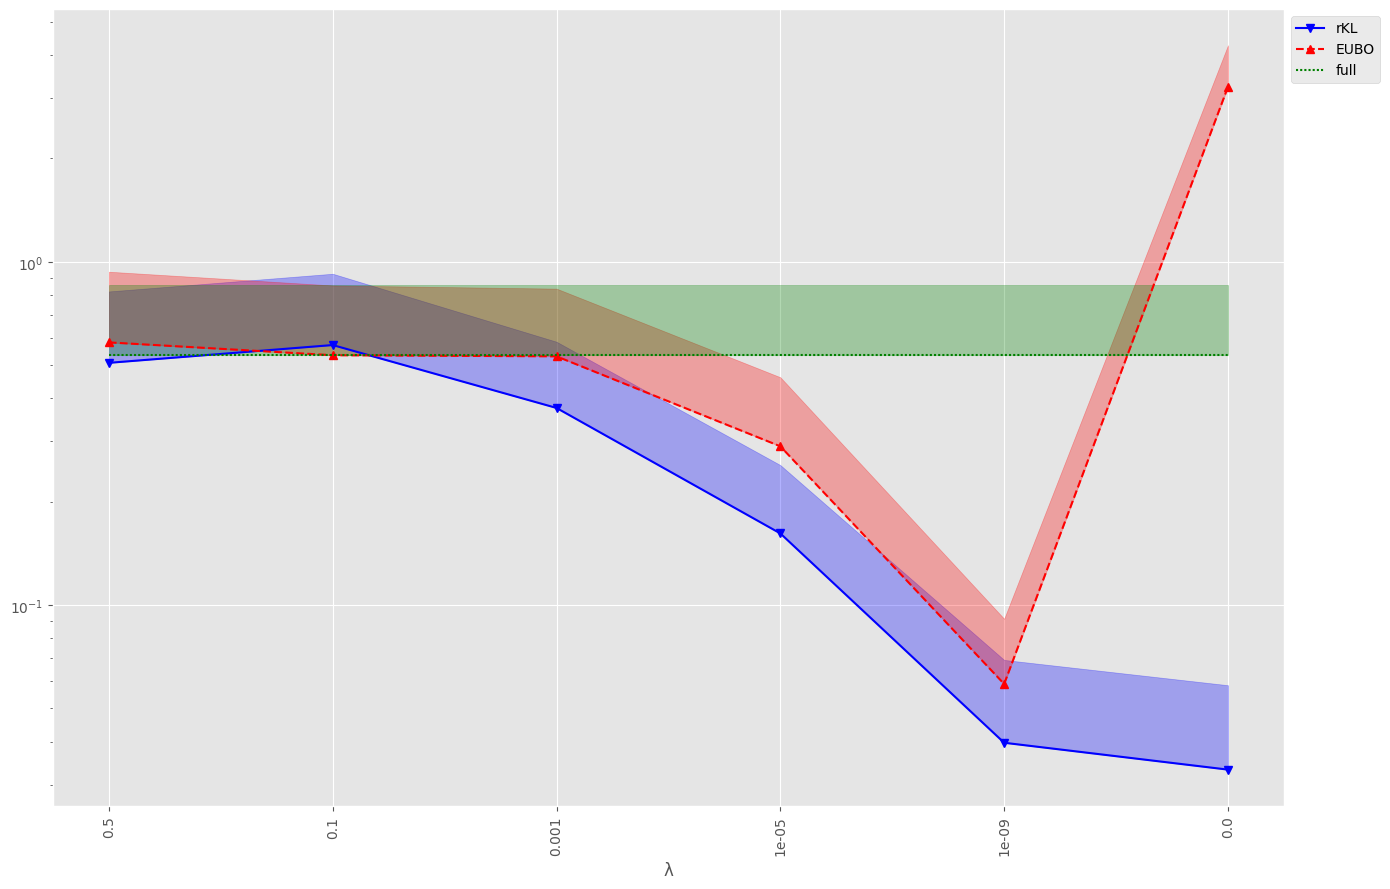

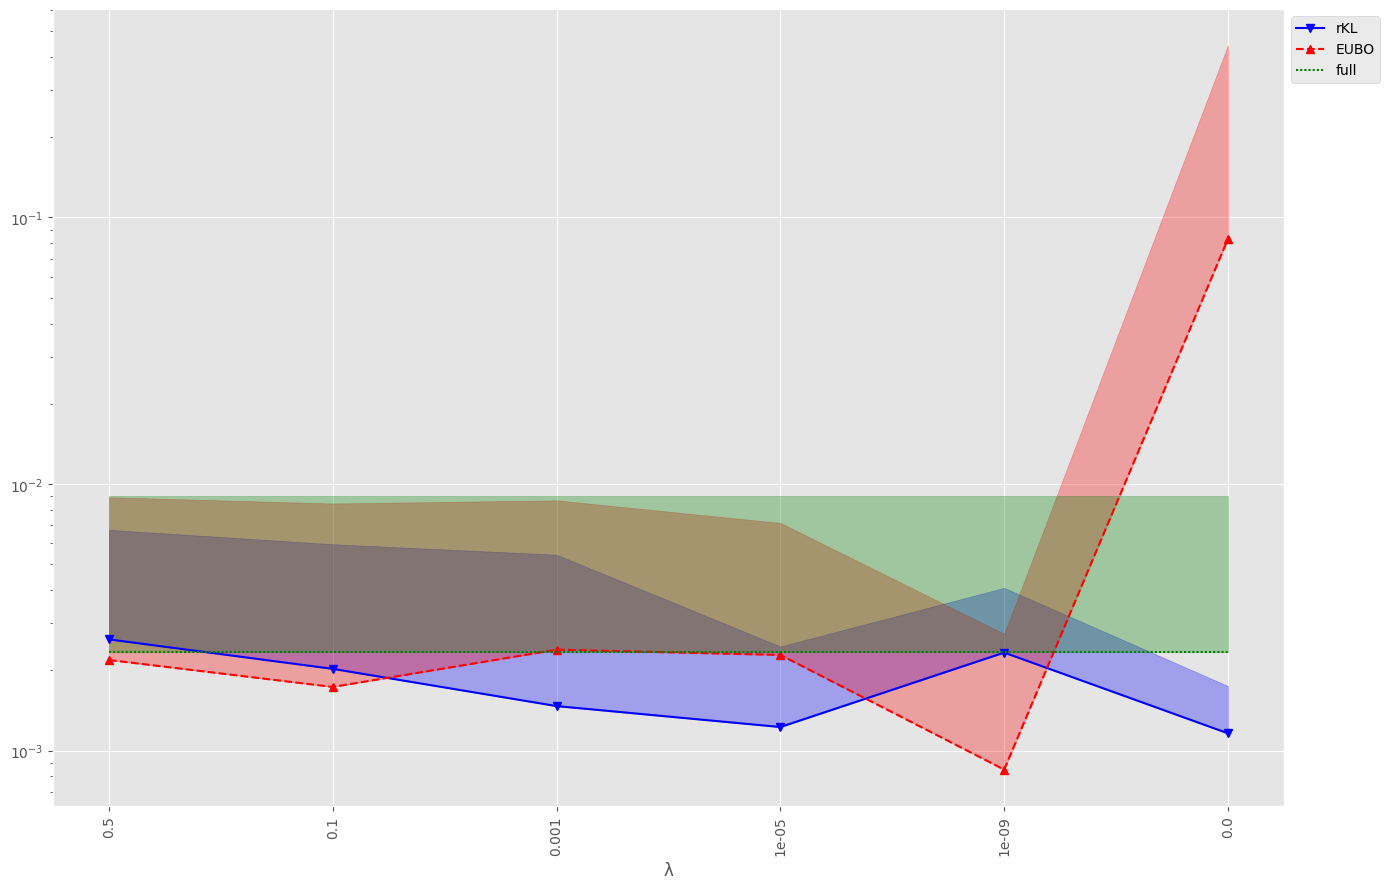

In [ ]:
# !python plot_kl_distance_mean_std.py --folder result/plot_data --exper moon --appr gauss_fullcov

import numpy as np
import pickle
import sys
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['text.usetex'] = False
folder = "result/plot_data"
experiment = "moon"
approximate = "gauss_fullcov"

plot_retrain_vs_full = True
plot_legend = True
plot_eubo = True

plot_data = pickle.load(
    open("{}/likelihood_diff_{}_{}.p".format(folder, experiment, approximate), "rb"))

full_elbo_mode_percentages = plot_data["elbo_mode_percentage"]
full_eubo_mode_percentages = plot_data["eubo_mode_percentage"]

removed_likelihood_diffs = plot_data["removed_likelihood_diff"]
remain_likelihood_diffs = plot_data["remain_likelihood_diff"]

std_removed_likelihood_diffs = plot_data["std_removed_likelihood_diff"]
std_remain_likelihood_diffs = plot_data["std_remain_likelihood_diff"]

if experiment.startswith("moon"):
    selected_percentages = [0.5, 0.1, 1e-3, 1e-5, 1e-9, 0.0]
elif experiment == "banknote_authentication1":
    if approximate == "gauss_fullcov":
        selected_percentages = [.5, .1, 1e-3, 1e-5, 1e-9, 0.0]
    elif approximate == "maf":
        selected_percentages = [1e-3, 1e-5, 1e-7, 1e-9, 0.0]
else:
    raise Exception("Unknown experiment {}".format(experiment))

remove_idxs = []
for i,percentage in enumerate(full_elbo_mode_percentages):
    if percentage not in selected_percentages:
        remove_idxs.append(i)

removed_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(removed_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
removed_likelihood_diffs["elbo"]["vs_full"] = np.delete(removed_likelihood_diffs["elbo"]["vs_full"], remove_idxs)
remain_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(remain_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
remain_likelihood_diffs["elbo"]["vs_full"] = np.delete(remain_likelihood_diffs["elbo"]["vs_full"], remove_idxs)

std_removed_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(std_removed_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
std_removed_likelihood_diffs["elbo"]["vs_full"] = np.delete(std_removed_likelihood_diffs["elbo"]["vs_full"], remove_idxs)
std_remain_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(std_remain_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
std_remain_likelihood_diffs["elbo"]["vs_full"] = np.delete(std_remain_likelihood_diffs["elbo"]["vs_full"], remove_idxs)

if plot_eubo:
    remove_idxs = []
    for i,percentage in enumerate(full_eubo_mode_percentages):
        if percentage not in selected_percentages:
            remove_idxs.append(i)

    removed_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(removed_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    removed_likelihood_diffs["eubo"]["vs_full"] = np.delete(removed_likelihood_diffs["eubo"]["vs_full"], remove_idxs)
    remain_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(remain_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    remain_likelihood_diffs["eubo"]["vs_full"] = np.delete(remain_likelihood_diffs["eubo"]["vs_full"], remove_idxs)

    std_removed_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(std_removed_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    std_removed_likelihood_diffs["eubo"]["vs_full"] = np.delete(std_removed_likelihood_diffs["eubo"]["vs_full"], remove_idxs)
    std_remain_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(std_remain_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    std_remain_likelihood_diffs["eubo"]["vs_full"] = np.delete(std_remain_likelihood_diffs["eubo"]["vs_full"], remove_idxs)

    print("EUBO percentages", full_eubo_mode_percentages)

print("ELBO percentages", full_elbo_mode_percentages)
print("selected percentages", selected_percentages)

if plot_eubo:
    assert len(full_eubo_mode_percentages) == len(full_elbo_mode_percentages)
n = len(selected_percentages)

if plot_legend:
    figsize = (2.8*5,1.8*5)
else:
    figsize = (1.8*5,1.8*5)

fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.plot(list(range(n)), removed_likelihood_diffs["elbo"]["vs_retrain"],
               linestyle='-',
               color='blue',
               marker='v', label='rKL')
ax.fill_between(list(range(n)), removed_likelihood_diffs["elbo"]["vs_retrain"],
               removed_likelihood_diffs["elbo"]["vs_retrain"] + std_removed_likelihood_diffs["elbo"]["vs_retrain"],
               color='blue',
               alpha=0.3)

if plot_eubo:
    ax.plot(list(range(n)), removed_likelihood_diffs["eubo"]["vs_retrain"],
                linestyle='--',
                color='red',
                marker='^', label='EUBO')
    ax.fill_between(list(range(n)), removed_likelihood_diffs["eubo"]["vs_retrain"],
                removed_likelihood_diffs["eubo"]["vs_retrain"] + std_removed_likelihood_diffs["eubo"]["vs_retrain"],
                color='red',
                alpha=0.3)

if plot_retrain_vs_full:
    ax.plot(list(range(n)), np.ones(n) * removed_likelihood_diffs['full_vs_retrain'],
            linestyle=(0,(1,1)),
            color='green',
            label='full')
    ax.fill_between(list(range(n)), np.ones(n) * removed_likelihood_diffs['full_vs_retrain'],
            removed_likelihood_diffs['full_vs_retrain'] + np.ones(n) * std_removed_likelihood_diffs['full_vs_retrain'],
            color='green',
            alpha=0.3)

ax.set_yscale("log")
ax.set_xticks(range(n))
ax.set_xticklabels(labels=[str(i) for i in selected_percentages], rotation=90)
ax.set_xlabel("λ")

if plot_legend:
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

print('ok 1')

ax.plot(list(range(n)), remain_likelihood_diffs["elbo"]["vs_retrain"],
          linestyle='-',
            color='blue',
            marker='v', label='rKL')
ax.fill_between(list(range(n)), remain_likelihood_diffs["elbo"]["vs_retrain"],
            std_remain_likelihood_diffs["elbo"]["vs_retrain"],
            color='blue',
            alpha=0.3)

if plot_eubo:
    ax.plot(list(range(n)), remain_likelihood_diffs["eubo"]["vs_retrain"],
                linestyle='--',
                color='red',
                marker='^', label='EUBO')
    ax.fill_between(list(range(n)), remain_likelihood_diffs["eubo"]["vs_retrain"],
                remain_likelihood_diffs["eubo"]["vs_retrain"] + std_remain_likelihood_diffs["eubo"]["vs_retrain"],
                color='red',
                alpha=0.3)

if plot_retrain_vs_full:
    ax.plot(list(range(n)), np.ones(n) * remain_likelihood_diffs['full_vs_retrain'],
            linestyle=(0,(1,1)),
            color='green',
            label='full')
    ax.fill_between(list(range(n)), np.ones(n) * remain_likelihood_diffs['full_vs_retrain'],
            remain_likelihood_diffs['full_vs_retrain'] + np.ones(n) * std_remain_likelihood_diffs['full_vs_retrain'],
            color='green',
            alpha=0.3)

print('ok 2')

ax.set_yscale("log")
ax.set_xticks(range(n))
ax.set_xticklabels(labels=[str(i) for i in selected_percentages], rotation=90)
ax.set_xlabel("λ")

print('ok 3')

if plot_legend:
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

print('ok 4')

plt.show()

2024-04-08 16:17:46.240822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 16:17:46.240879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 16:17:46.242291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


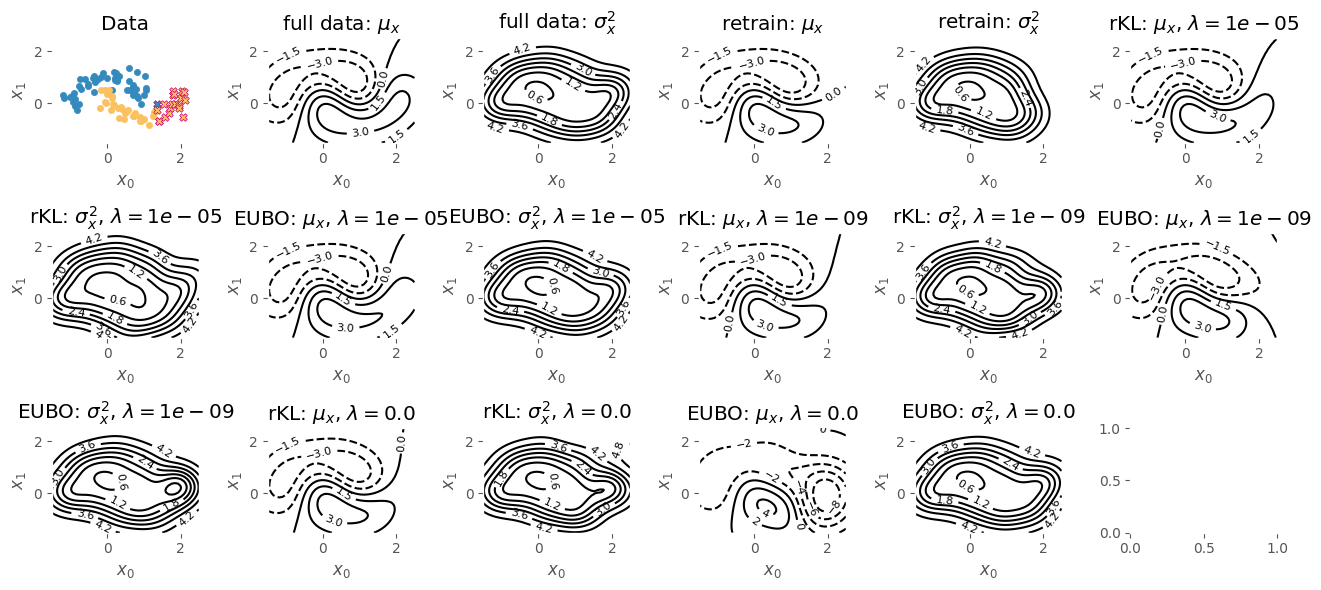

In [ ]:
# !cd result; python ../plot_moon_gauss.py --exper moon

import numpy as np
import pickle


import matplotlib

from matplotlib import rc
rc('text', usetex=False)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.facecolor']='w'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import model_config
from run import make_approximate


def num2str(num):
    return str(num).replace('.', '_')


# import argparse


# parser = argparse.ArgumentParser(description='Plot the data, posterior mean and variance of the synthetic moon classification dataset.')

# parser.add_argument('--exper', help='in {moon, moon_random, moon_rm_30, moon_rm_40, moon_rm_50}',
#                     required=False,
#                     type=str,
#                     default='moon')


# args = parser.parse_args()


nbijector = 15
nhidden = 5

# experiment = args.exper
experiment = "moon"
approximate = "gauss_fullcov"


approximate_dist, approximate_config = make_approximate(approximate, nbijector, nhidden)
experiment_data = model_config.get_experiment(experiment)

dim = experiment_data['dim']
nparam = experiment_data['nparam']
model = experiment_data['model']
data = experiment_data['data']
remain_data = experiment_data['remain_data']
removed_data = experiment_data['removed_data']
ndata = data.shape[0]

prefix = "result/result/{}/{}".format(experiment, approximate)
selected_percentages = [1e-5, 1e-9, 0.0]


n = 50
plot_xmin = -1.5
plot_xmax = 2.5

x1d = np.linspace(plot_xmin, plot_xmax, n)
x1,x2 = np.meshgrid(x1d, x1d)
x = np.stack([x1.flatten(), x2.flatten()]).T

full_params = pickle.load(open("{}/full_data_post.p".format(prefix), "rb"))
full_meanf, full_varf = model.predict_f(x,
                        full_params['loc'],
                        full_params['sqrt_cov'].dot(full_params['sqrt_cov'].T))

remain_params = pickle.load(open("{}/remain_data_retrain_post.p".format(prefix), "rb"))
remain_meanf, remain_varf = model.predict_f(x,
                        remain_params['loc'],
                        remain_params['sqrt_cov'].dot(remain_params['sqrt_cov'].T))

elbo_meanf = {}
elbo_varf = {}

eubo_meanf = {}
eubo_varf = {}

for percentage in selected_percentages:
    elbo_params = pickle.load(open("{}/data_remain_data_by_unlearn_elbo_{}.p".format(prefix, percentage), "rb"))
    elbo_meanf[percentage], elbo_varf[percentage] = model.predict_f(x,
                            elbo_params['loc'],
                            elbo_params['sqrt_cov'].dot(elbo_params['sqrt_cov'].T))

    eubo_params = pickle.load(open("{}/data_remain_data_by_unlearn_eubo_{}.p".format(prefix, percentage), "rb"))
    eubo_meanf[percentage], eubo_varf[percentage] = model.predict_f(x,
                            eubo_params['loc'],
                            eubo_params['sqrt_cov'].dot(eubo_params['sqrt_cov'].T))

figsize = (2.2*6, 2.*3)

fig, axs = plt.subplots(3,6, figsize=figsize, tight_layout=True)

axs[0,0].scatter(remain_data[np.where(remain_data[:,-1] == 0),0],
           remain_data[np.where(remain_data[:,-1] == 0),1],
           marker='o', c=colors[1], s=20)
axs[0,0].scatter(remain_data[np.where(remain_data[:,-1] == 1),0],
           remain_data[np.where(remain_data[:,-1] == 1),1],
           marker='o', c=colors[4], s=20)


sc = axs[0,0].scatter(removed_data[np.where(removed_data[:,-1] == 0),0],
           removed_data[np.where(removed_data[:,-1] == 0),1],
           marker='X', c=colors[1], s=30)
sc.set_edgecolor('#C7006E')
sc = axs[0,0].scatter(removed_data[np.where(removed_data[:,-1] == 1),0],
           removed_data[np.where(removed_data[:,-1] == 1),1],
           marker='X', c=colors[4], s=30)
sc.set_edgecolor('#C7006E')

axs[0,0].set_xlim(plot_xmin, plot_xmax)
axs[0,0].set_ylim(plot_xmin, plot_xmax)

axs[0,0].set_xlabel(r'$x_0$')
axs[0,0].set_ylabel(r'$x_1$')
axs[0,0].set_title("Data")

contour = axs[0,1].contour(x1, x2, full_meanf.reshape(n,n), origin='lower', colors='black')
axs[0,1].clabel(contour, inline=True, fontsize=8)
axs[0,1].set_xlabel(r'$x_0$')
axs[0,1].set_ylabel(r'$x_1$')
axs[0,1].grid(False)
axs[0,1].set_title(r"full data: $\mu_x$")

contour = axs[0,2].contour(x1, x2, full_varf.reshape(n,n), origin='lower', colors='black')
axs[0,2].clabel(contour, inline=True, fontsize=8)
axs[0,2].set_xlabel(r'$x_0$')
axs[0,2].set_ylabel(r'$x_1$')
axs[0,2].grid(False)
axs[0,2].set_title(r"full data: $\sigma^2_x$")


contour = axs[0,3].contour(x1, x2, remain_meanf.reshape(n,n), origin='lower', colors='black')
axs[0,3].clabel(contour, inline=True, fontsize=8)
axs[0,3].set_xlabel(r'$x_0$')
axs[0,3].set_ylabel(r'$x_1$')
axs[0,3].grid(False)
axs[0,3].set_title(r"retrain: $\mu_x$")

contour = axs[0,4].contour(x1, x2, remain_varf.reshape(n,n), origin='lower', colors='black')
axs[0,4].clabel(contour, inline=True, fontsize=8)
axs[0,4].set_xlabel(r'$x_0$')
axs[0,4].set_ylabel(r'$x_1$')
axs[0,4].grid(False)
axs[0,4].set_title(r"retrain: $\sigma^2_x$")

plot_idx = 5
for percentage in selected_percentages:
    contour = axs[int(plot_idx/6),plot_idx%6].contour(x1, x2, elbo_meanf[percentage].reshape(n,n), origin='lower', colors='black')
    axs[int(plot_idx/6),plot_idx%6].clabel(contour, inline=True, fontsize=8)
    axs[int(plot_idx/6),plot_idx%6].set_xlabel(r'$x_0$')
    axs[int(plot_idx/6),plot_idx%6].set_ylabel(r'$x_1$')
    axs[int(plot_idx/6),plot_idx%6].grid(False)
    axs[int(plot_idx/6),plot_idx%6].set_title(r"rKL: $\mu_x$, $\lambda={}$".format(percentage))

    plot_idx += 1

    contour = axs[int(plot_idx/6),plot_idx%6].contour(x1, x2, elbo_varf[percentage].reshape(n,n), origin='lower', colors='black')
    axs[int(plot_idx/6),plot_idx%6].clabel(contour, inline=True, fontsize=8)
    axs[int(plot_idx/6),plot_idx%6].set_xlabel(r'$x_0$')
    axs[int(plot_idx/6),plot_idx%6].set_ylabel(r'$x_1$')
    axs[int(plot_idx/6),plot_idx%6].grid(False)
    axs[int(plot_idx/6),plot_idx%6].set_title(r"rKL: $\sigma^2_x$, $\lambda={}$".format(percentage))

    plot_idx += 1

    contour = axs[int(plot_idx/6),plot_idx%6].contour(x1, x2, eubo_meanf[percentage].reshape(n,n), origin='lower', colors='black')
    axs[int(plot_idx/6),plot_idx%6].clabel(contour, inline=True, fontsize=8)
    axs[int(plot_idx/6),plot_idx%6].set_xlabel(r'$x_0$')
    axs[int(plot_idx/6),plot_idx%6].set_ylabel(r'$x_1$')
    axs[int(plot_idx/6),plot_idx%6].grid(False)
    axs[int(plot_idx/6),plot_idx%6].set_title(r"EUBO: $\mu_x$, $\lambda={}$".format(percentage))

    plot_idx += 1

    contour = axs[int(plot_idx/6),plot_idx%6].contour(x1, x2, eubo_varf[percentage].reshape(n,n), origin='lower', colors='black')
    axs[int(plot_idx/6),plot_idx%6].clabel(contour, inline=True, fontsize=8)
    axs[int(plot_idx/6),plot_idx%6].set_xlabel(r'$x_0$')
    axs[int(plot_idx/6),plot_idx%6].set_ylabel(r'$x_1$')
    axs[int(plot_idx/6),plot_idx%6].grid(False)
    axs[int(plot_idx/6),plot_idx%6].set_title(r"EUBO: $\sigma^2_x$, $\lambda={}$".format(percentage))

    plot_idx += 1

plt.show()

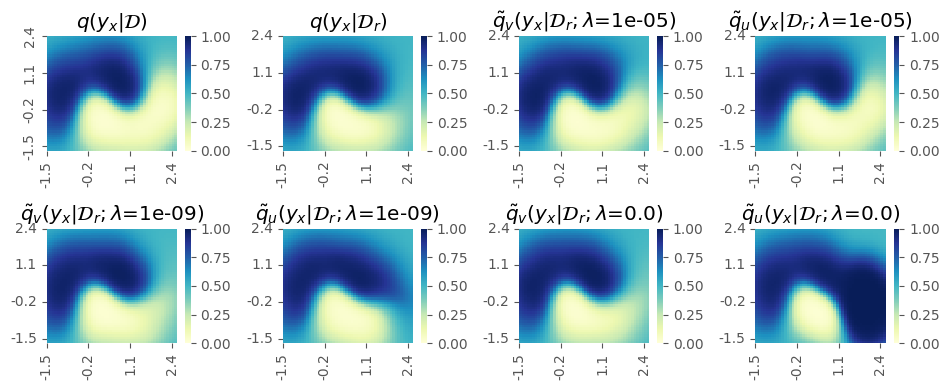

In [ ]:
# !cd result; python ../plot_moon_marginal_prob.py --exper moon

import numpy as np
import pickle
import tensorflow.compat.v1 as tf # Disable TensorFlow 2.x behavior and enable TensorFlow 1.x behavior
tf.disable_v2_behavior()
import scipy.special

import matplotlib

from matplotlib import rc
rc('text', usetex=False)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import seaborn
plt.style.use('ggplot')

plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.facecolor']='w'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import model_config
from run import make_approximate


def num2str(num):
    return str(num).replace('.', '_')


# import argparse


# parser = argparse.ArgumentParser(description='Plot the data, posterior mean and variance of the synthetic moon classification dataset.')

# parser.add_argument('--exper', help='in {moon, moon_random, moon_rm_30, moon_rm_40, moon_rm_50}',
#                     required=False,
#                     type=str,
#                     default='moon')


# args = parser.parse_args()


nbijector = 15
nhidden = 5

experiment = "moon"
approximate = "gauss_fullcov"
show_cbar = True


approximate_dist, approximate_config = make_approximate(approximate, nbijector, nhidden)
experiment_data = model_config.get_experiment(experiment)

dim = experiment_data['dim']
nparam = experiment_data['nparam']
model = experiment_data['model']
data = experiment_data['data']
remain_data = experiment_data['remain_data']
removed_data = experiment_data['removed_data']
ndata = data.shape[0]

prefix = "result/result/{}/{}".format(experiment, approximate)
selected_percentages = [1e-5,1e-9, 0.0]

n = 50
plot_xmin = -1.5
plot_xmax = 2.5

x1d = np.linspace(plot_xmin, plot_xmax, n)
x1,x2 = np.meshgrid(x1d, x1d)
x = np.stack([x1.flatten(), x2.flatten()]).T



def padding_dummy_output(data_x):
    # data_x: (n,dim-1)
    # append zero class label to the last column
    return np.concatenate([data_x, np.zeros([data_x.shape[0],1])], axis=1)

n_param_samples = 100
param_sample_batch = 100
n_iter = int(n_param_samples / param_sample_batch)

approx_dist, approx_config = make_approximate(approximate, nbijector, nhidden=5)
approx_model = approx_dist(experiment_data['nparam'], **approx_config)

param_samples = approx_model.sample(param_sample_batch)
posterior_lprobs = experiment_data['model'].log_posterior_predictive(param_samples, padding_dummy_output(x).astype(np.float64))
# (nclass,ndata,nsample)


def get_posterior_lprobs(learned_param):
    with tf.Session() as sess:
        approx_model.load_param(learned_param, sess)

        posterior_lprobs_np = []

        for _ in range(n_iter):
            posterior_lprobs_i = sess.run(posterior_lprobs)

            posterior_lprobs_i = scipy.special.logsumexp(posterior_lprobs_i, axis=2, keepdims=True) - np.log(posterior_lprobs_i.shape[2])
            # (nclass, ndata, 1)

            posterior_lprobs_np.append(posterior_lprobs_i)

        posterior_lprobs_np = np.concatenate(posterior_lprobs_np, axis=2) # concat over the sample dimension
        # (nclass, ndata, n_param_samples)

        posterior_lprobs_np = scipy.special.logsumexp(posterior_lprobs_np, axis=2) - np.log(posterior_lprobs_np.shape[2])
    return posterior_lprobs_np
    # (nclass, ndata)




full_params = pickle.load(open("{}/full_data_post.p".format(prefix), "rb"))
remain_params = pickle.load(open("{}/remain_data_retrain_post.p".format(prefix), "rb"))

full_probs = np.exp(get_posterior_lprobs(full_params))
remain_probs = np.exp(get_posterior_lprobs(remain_params))

elbo_probs = {}
eubo_probs = {}

for percentage in selected_percentages:
    elbo_params = pickle.load(open("{}/data_remain_data_by_unlearn_elbo_{}.p".format(prefix, percentage), "rb"))
    elbo_probs[percentage] = np.exp(get_posterior_lprobs(elbo_params))

    eubo_params = pickle.load(open("{}/data_remain_data_by_unlearn_eubo_{}.p".format(prefix, percentage), "rb"))
    eubo_probs[percentage] = np.exp(get_posterior_lprobs(eubo_params))


figsize = (2.4*4, 2.*2)

fig, axs = plt.subplots(2,4,figsize=figsize, tight_layout=True)
hm = seaborn.heatmap(np.flipud(full_probs[1,:].reshape(n,n)), vmin=0, vmax=1, cmap="YlGnBu", ax=axs[0,0], cbar=show_cbar)
hm.set(xticks=list(range(0,50,16)))
hm.set(xticklabels=["{:.1f}".format(i) for i in x1d[list(range(0,50,16))]])
hm.set(yticks=list(range(0,50,16)))
hm.set(yticklabels=["{:.1f}".format(i) for i in x1d[list(reversed(range(0,50,16)))]])
axs[0,0].grid(False)

axs[0,0].set_title(r"$q(y_x|\mathcal{D})$")


hm = seaborn.heatmap(np.flipud(remain_probs[1,:].reshape(n,n)), vmin=0, vmax=1, cmap="YlGnBu", ax=axs[0,1], cbar=show_cbar)
hm.set(xticks=list(range(0,50,16)))
hm.set(xticklabels=["{:.1f}".format(i) for i in x1d[list(range(0,50,16))]])
hm.set(yticks=list(range(0,50,16)))
hm.set(yticklabels=["{:.1f}".format(i) for i in x1d[list(reversed(range(0,50,16)))]])
axs[0,1].grid(False)

axs[0,1].set_title(r"$q(y_x|\mathcal{D}_r)$")

plot_idx = 2

for percentage in selected_percentages:
    axs[int(plot_idx/4), plot_idx%4].grid(False)
    hm = seaborn.heatmap(np.flipud(elbo_probs[percentage][1,:].reshape(n,n)), vmin=0, vmax=1, cmap="YlGnBu", ax=axs[int(plot_idx/4), plot_idx%4], cbar=show_cbar)
    hm.set(xticks=list(range(0,50,16)))
    hm.set(xticklabels=["{:.1f}".format(i) for i in x1d[list(range(0,50,16))]])
    hm.set(yticks=list(range(0,50,16)))
    hm.set(yticklabels=["{:.1f}".format(i) for i in x1d[list(reversed(range(0,50,16)))]])

    axs[int(plot_idx/4), plot_idx%4].set_title(r'$\tilde{q}_v(y_x|\mathcal{D}_r;$' + "$\lambda$={}".format(percentage) + r"$)$")

    plot_idx += 1

    hm = seaborn.heatmap(np.flipud(eubo_probs[percentage][1,:].reshape(n,n)), vmin=0, vmax=1, cmap="YlGnBu", ax=axs[int(plot_idx/4), plot_idx%4], cbar=show_cbar)
    hm.set(xticks=list(range(0,50,16)))
    hm.set(xticklabels=["{:.1f}".format(i) for i in x1d[list(range(0,50,16))]])
    hm.set(yticks=list(range(0,50,16)))
    hm.set(yticklabels=["{:.1f}".format(i) for i in x1d[list(reversed(range(0,50,16)))]])
    axs[int(plot_idx/4), plot_idx%4].grid(False)

    axs[int(plot_idx/4), plot_idx%4].set_title(r'$\tilde{q}_u(y_x|\mathcal{D}_r;$' + "$\lambda$={}".format(percentage) + r"$)$")

    plot_idx += 1

plt.show()

## Banknote

In [ ]:
!python run.py --exper banknote_authentication1 --appr gauss_fullcov --nsample 1000 --ntrain 30000 --folder result --gpu 1

2024-04-08 16:19:04.378381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 16:19:04.378433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 16:19:04.379789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
exper banknote_authentication1
appr gauss_fullcov
nbijector 5
nhidden 30
nsample 1000
ntrain 30000
batchsize 1000000
folder result
gpu 1
Path to save output files: result/banknote_authentication1/gauss_fullcov
sample_data_np: Reading from dataset: banknote. Ignore xbound
2024-04-08 16:19:10.122064: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274]

In [ ]:
!python run.py --exper banknote_authentication1 --appr maf --nbijector 15 --nhidden 5 --nsample 1000 --ntrain 30000 --folder result --gpu 1

2024-04-09 20:33:25.103322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 20:33:25.103392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 20:33:25.105042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
exper banknote_authentication1
appr maf
nbijector 15
nhidden 5
nsample 1000
ntrain 30000
batchsize 1000000
folder result
gpu 1
Path to save output files: result/banknote_authentication1/maf
sample_data_np: Reading from dataset: banknote. Ignore xbound
Remaining data: (960, 5)
Removed data: (412, 5)
Load from result/banknote_authentication1/maf/full_data_post.p
Lo

In [ ]:
%cd variational-bayesian-unlearning

/kaggle/working/variational-bayesian-unlearning


In [ ]:
!ls plot_data

ls: cannot access 'plot_data': No such file or directory


In [ ]:
!python compute_kl_distance.py --folder result --outfolder result/plot_data --exper banknote_authentication1 --appr maf

2024-04-09 21:57:18.213069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 21:57:18.213163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 21:57:18.215214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
sample_data_np: Reading from dataset: banknote. Ignore xbound
Likelihood of full-data posterior
Likelihood of re-trained posterior
Likelihood of ELBO unlearned posterior 0.001
Likelihood of ELBO unlearned posterior 1e-05
Likelihood of ELBO unlearned posterior 1e-07
Likelihood of ELBO unlearned posterior 1e-09
Likelihood of ELBO unlearned posterior 0.0
Likelihood 

In [ ]:
!ls /kaggle/working/variational-bayesian-unlearning/result/plot_data

likelihood_diff_banknote_authentication1_maf.p
likelihood_diff_moon_gauss_fullcov.p


EUBO percentages [0.001, 1e-05, 1e-07, 1e-09, 0.0]
ELBO percentages [0.001, 1e-05, 1e-07, 1e-09, 0.0]
selected percentages [0.001, 1e-05, 1e-07, 1e-09, 0.0]
ok 1
ok 2
ok 3
ok 4


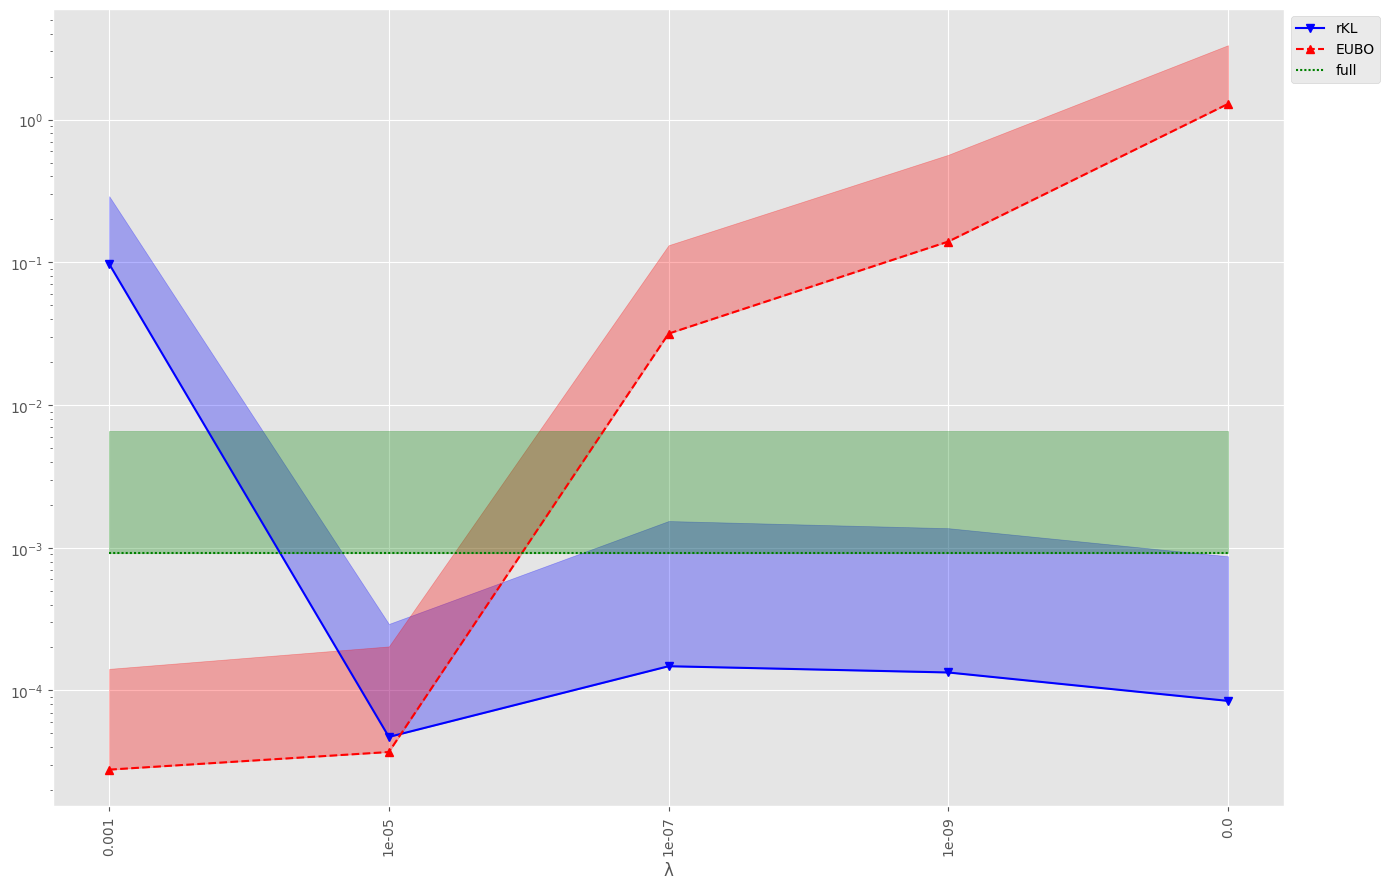

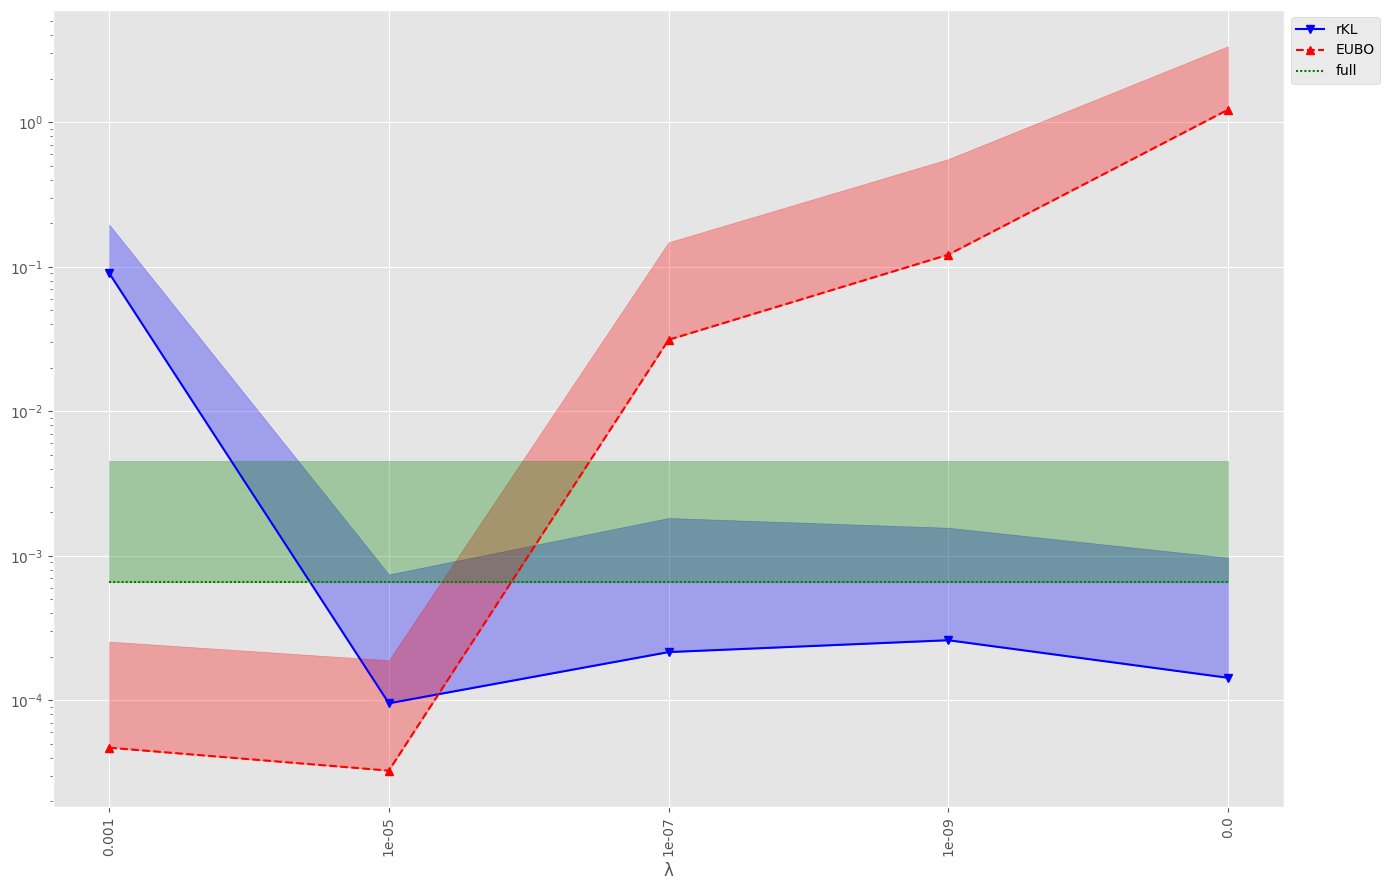

In [ ]:
# !python plot_kl_distance_mean_std.py --folder plot_data --exper banknote_authentication1 --appr maf

import numpy as np
import pickle
import sys
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['text.usetex'] = False
folder = "/kaggle/working/variational-bayesian-unlearning/result/plot_data"
experiment = "banknote_authentication1"
approximate = "maf"

plot_retrain_vs_full = True
plot_legend = True
plot_eubo = True

plot_data = pickle.load(
    open("{}/likelihood_diff_{}_{}.p".format(folder, experiment, approximate), "rb"))

full_elbo_mode_percentages = plot_data["elbo_mode_percentage"]
full_eubo_mode_percentages = plot_data["eubo_mode_percentage"]

removed_likelihood_diffs = plot_data["removed_likelihood_diff"]
remain_likelihood_diffs = plot_data["remain_likelihood_diff"]

std_removed_likelihood_diffs = plot_data["std_removed_likelihood_diff"]
std_remain_likelihood_diffs = plot_data["std_remain_likelihood_diff"]

if experiment.startswith("moon"):
    selected_percentages = [0.5, 0.1, 1e-3, 1e-5, 1e-9, 0.0]
elif experiment == "banknote_authentication1":
    if approximate == "gauss_fullcov":
        selected_percentages = [.5, .1, 1e-3, 1e-5, 1e-9, 0.0]
    elif approximate == "maf":
        selected_percentages = [1e-3, 1e-5, 1e-7, 1e-9, 0.0]
else:
    raise Exception("Unknown experiment {}".format(experiment))

remove_idxs = []
for i,percentage in enumerate(full_elbo_mode_percentages):
    if percentage not in selected_percentages:
        remove_idxs.append(i)

removed_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(removed_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
removed_likelihood_diffs["elbo"]["vs_full"] = np.delete(removed_likelihood_diffs["elbo"]["vs_full"], remove_idxs)
remain_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(remain_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
remain_likelihood_diffs["elbo"]["vs_full"] = np.delete(remain_likelihood_diffs["elbo"]["vs_full"], remove_idxs)

std_removed_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(std_removed_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
std_removed_likelihood_diffs["elbo"]["vs_full"] = np.delete(std_removed_likelihood_diffs["elbo"]["vs_full"], remove_idxs)
std_remain_likelihood_diffs["elbo"]["vs_retrain"] = np.delete(std_remain_likelihood_diffs["elbo"]["vs_retrain"], remove_idxs)
std_remain_likelihood_diffs["elbo"]["vs_full"] = np.delete(std_remain_likelihood_diffs["elbo"]["vs_full"], remove_idxs)

if plot_eubo:
    remove_idxs = []
    for i,percentage in enumerate(full_eubo_mode_percentages):
        if percentage not in selected_percentages:
            remove_idxs.append(i)

    removed_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(removed_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    removed_likelihood_diffs["eubo"]["vs_full"] = np.delete(removed_likelihood_diffs["eubo"]["vs_full"], remove_idxs)
    remain_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(remain_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    remain_likelihood_diffs["eubo"]["vs_full"] = np.delete(remain_likelihood_diffs["eubo"]["vs_full"], remove_idxs)

    std_removed_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(std_removed_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    std_removed_likelihood_diffs["eubo"]["vs_full"] = np.delete(std_removed_likelihood_diffs["eubo"]["vs_full"], remove_idxs)
    std_remain_likelihood_diffs["eubo"]["vs_retrain"] = np.delete(std_remain_likelihood_diffs["eubo"]["vs_retrain"], remove_idxs)
    std_remain_likelihood_diffs["eubo"]["vs_full"] = np.delete(std_remain_likelihood_diffs["eubo"]["vs_full"], remove_idxs)

    print("EUBO percentages", full_eubo_mode_percentages)

print("ELBO percentages", full_elbo_mode_percentages)
print("selected percentages", selected_percentages)

if plot_eubo:
    assert len(full_eubo_mode_percentages) == len(full_elbo_mode_percentages)
n = len(selected_percentages)

if plot_legend:
    figsize = (2.8*5,1.8*5)
else:
    figsize = (1.8*5,1.8*5)

fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

ax.plot(list(range(n)), removed_likelihood_diffs["elbo"]["vs_retrain"],
               linestyle='-',
               color='blue',
               marker='v', label='rKL')
ax.fill_between(list(range(n)), removed_likelihood_diffs["elbo"]["vs_retrain"],
               removed_likelihood_diffs["elbo"]["vs_retrain"] + std_removed_likelihood_diffs["elbo"]["vs_retrain"],
               color='blue',
               alpha=0.3)

if plot_eubo:
    ax.plot(list(range(n)), removed_likelihood_diffs["eubo"]["vs_retrain"],
                linestyle='--',
                color='red',
                marker='^', label='EUBO')
    ax.fill_between(list(range(n)), removed_likelihood_diffs["eubo"]["vs_retrain"],
                removed_likelihood_diffs["eubo"]["vs_retrain"] + std_removed_likelihood_diffs["eubo"]["vs_retrain"],
                color='red',
                alpha=0.3)

if plot_retrain_vs_full:
    ax.plot(list(range(n)), np.ones(n) * removed_likelihood_diffs['full_vs_retrain'],
            linestyle=(0,(1,1)),
            color='green',
            label='full')
    ax.fill_between(list(range(n)), np.ones(n) * removed_likelihood_diffs['full_vs_retrain'],
            removed_likelihood_diffs['full_vs_retrain'] + np.ones(n) * std_removed_likelihood_diffs['full_vs_retrain'],
            color='green',
            alpha=0.3)

ax.set_yscale("log")
ax.set_xticks(range(n))
ax.set_xticklabels(labels=[str(i) for i in selected_percentages], rotation=90)
ax.set_xlabel("λ")

if plot_legend:
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

print('ok 1')

ax.plot(list(range(n)), remain_likelihood_diffs["elbo"]["vs_retrain"],
          linestyle='-',
            color='blue',
            marker='v', label='rKL')
ax.fill_between(list(range(n)), remain_likelihood_diffs["elbo"]["vs_retrain"],
            std_remain_likelihood_diffs["elbo"]["vs_retrain"],
            color='blue',
            alpha=0.3)

if plot_eubo:
    ax.plot(list(range(n)), remain_likelihood_diffs["eubo"]["vs_retrain"],
                linestyle='--',
                color='red',
                marker='^', label='EUBO')
    ax.fill_between(list(range(n)), remain_likelihood_diffs["eubo"]["vs_retrain"],
                remain_likelihood_diffs["eubo"]["vs_retrain"] + std_remain_likelihood_diffs["eubo"]["vs_retrain"],
                color='red',
                alpha=0.3)

if plot_retrain_vs_full:
    ax.plot(list(range(n)), np.ones(n) * remain_likelihood_diffs['full_vs_retrain'],
            linestyle=(0,(1,1)),
            color='green',
            label='full')
    ax.fill_between(list(range(n)), np.ones(n) * remain_likelihood_diffs['full_vs_retrain'],
            remain_likelihood_diffs['full_vs_retrain'] + np.ones(n) * std_remain_likelihood_diffs['full_vs_retrain'],
            color='green',
            alpha=0.3)

print('ok 2')

ax.set_yscale("log")
ax.set_xticks(range(n))
ax.set_xticklabels(labels=[str(i) for i in selected_percentages], rotation=90)
ax.set_xlabel("λ")

print('ok 3')

if plot_legend:
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))

print('ok 4')

plt.show()